In [1]:
from timeit import default_timer as timer
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
from datetime import datetime
import calendar
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
start_time = timer()

In [2]:
df = pd.read_csv('applications data.csv')

In [3]:
df.shape

(1000000, 10)

In [4]:
df.head(10)

record      date        ssn  firstname  lastname        address   zip5  \
0       1  20160101  379070012   XRRAMMTR  SMJETJMJ  6861 EUTST PL   2765   
1       2  20160101  387482503   MAMSTUJR  RTTEMRRR  7280 URASA PL  57169   
2       3  20160101  200332444  SZMMUJEZS  EUSEZRAE  5581 RSREX LN  56721   
3       4  20160101  747451317  SJJZSXRSZ  ETJXTXXS  1387 UJZXJ RD  35286   
4       5  20160101   24065868  SSSXUEJMS  SSUUJXUZ   279 EAASA WY   3173   
5       6  20160101  922264214  XEEJJSTER   ERJSAXA  4322 USJXU LN   8391   
6       7  20160101  415812149  XZJRJUSRR  STSMJRUM   478 EEXUM LN  41640   
7       8  20160101  373752050  EJMRRSUXR   AMTZXRU   8906 UUAJ PL  60567   
8       9  20160101  769970791  RXTSZJATS  RSXMRJME  8266 SSEAR RD  37934   
9      10  20160101  732119085  EREMTZXXA  EXMMSEXT  9166 XXSAZ PL  93751   

        dob   homephone  fraud_label  
0  19070626  1797504115            0  
1  19340615  4164239415            1  
2  19070626   216537580            0  
3  19440430   132144161            0  
4  19980315  6101082272            0  
5  19480613  5742016319            0  
6  19640318  7697396312            0  
7  19190528  2727421586            0  
8  19900314  5520652307            0  
9  19750127  3749451123            0

In [5]:
df.dtypes

record          int64
date            int64
ssn             int64
firstname      object
lastname       object
address        object
zip5            int64
dob             int64
homephone       int64
fraud_label     int64
dtype: object

In [6]:
# fix data type
df.set_index('date')
df['date'] = pd.to_datetime(
    df.date.astype(str).apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:]))

In [7]:
df['zip5'] = df['zip5'].apply(lambda x: '{0:0>5}'.format(x))

In [8]:
# data['appyear'] = (data['date'] / 10000).astype('int')
# data['appmonth'] = ((data['date'] - data['appyear'] * 10000) / 100).astype('int')
# data['appday'] = data['date'] - data['appyear'] * 10000 - data['appmonth'] * 100
# data['date'] = pd.to_datetime(data.appyear*10000+data.appmonth*100+data.appday,format='%Y%m%d')
# data = data.drop(columns = ['appyear','appmonth','appday'])

In [9]:
df.dtypes

record                  int64
date           datetime64[ns]
ssn                     int64
firstname              object
lastname               object
address                object
zip5                   object
dob                     int64
homephone               int64
fraud_label             int64
dtype: object

In [10]:
df.head()

record       date        ssn  firstname  lastname        address   zip5  \
0       1 2016-01-01  379070012   XRRAMMTR  SMJETJMJ  6861 EUTST PL  02765   
1       2 2016-01-01  387482503   MAMSTUJR  RTTEMRRR  7280 URASA PL  57169   
2       3 2016-01-01  200332444  SZMMUJEZS  EUSEZRAE  5581 RSREX LN  56721   
3       4 2016-01-01  747451317  SJJZSXRSZ  ETJXTXXS  1387 UJZXJ RD  35286   
4       5 2016-01-01   24065868  SSSXUEJMS  SSUUJXUZ   279 EAASA WY  03173   

        dob   homephone  fraud_label  
0  19070626  1797504115            0  
1  19340615  4164239415            1  
2  19070626   216537580            0  
3  19440430   132144161            0  
4  19980315  6101082272            0

In [11]:
# fix frivolous values
# ssn
df.loc[df.ssn == 999999999, 'ssn'] = -df[df.ssn == 999999999]['record']
df['ssn'] = df['ssn'].apply(lambda x: '{0:0>9}'.format(x))
# address
df.loc[df.address =='123 MAIN ST', 'address']=\
    df.loc[df.address == '123 MAIN ST','record'].apply(lambda x: str(x) + 'RECORD')
#dob
df.loc[df.dob == 19070626, 'dob'] = -df.loc[df.dob == 19070626]['record']
df['dob'] = df['dob'].apply(lambda x: '{0:0>8}'.format(x))
#homephone
df.loc[df.homephone == 9999999999,
       'homephone'] = -df.loc[df.homephone == 9999999999]['record']
df['homephone'] = df['homephone'].apply(lambda x: '{0:0>10}'.format(x))

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   record       1000000 non-null  int64         
 1   date         1000000 non-null  datetime64[ns]
 2   ssn          1000000 non-null  object        
 3   firstname    1000000 non-null  object        
 4   lastname     1000000 non-null  object        
 5   address      1000000 non-null  object        
 6   zip5         1000000 non-null  object        
 7   dob          1000000 non-null  object        
 8   homephone    1000000 non-null  object        
 9   fraud_label  1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 76.3+ MB


#### Make day of week target encoding

In [13]:
df['dow'] = df.date.apply(lambda x: calendar.day_name[x.weekday()])

In [14]:
train_test = df[df.date < '2016-11-01']

In [15]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg) / (1 + np.exp(-(num - nmid) / c))
df['dow_risk'] = df.dow.map(y_dow_smooth)

In [16]:
y_dow = y_dow.reset_index()
cats = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
]
y_dow['dow'] = pd.Categorical(y_dow['dow'], categories=cats, ordered=True)
y_dow = y_dow.sort_values('dow')
y_dow = y_dow.set_index('dow')

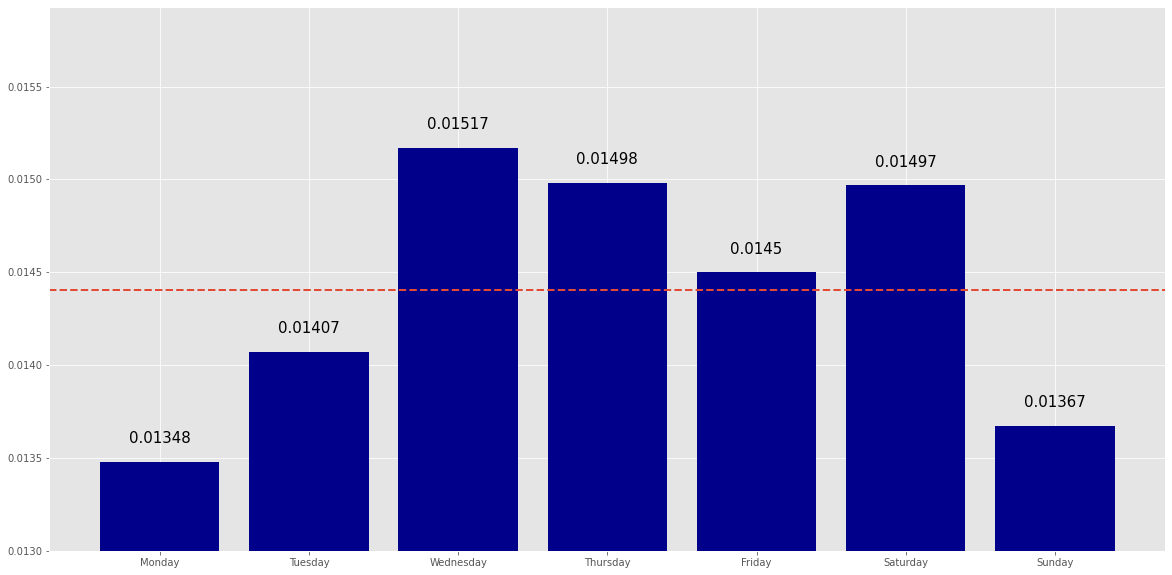

In [17]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(data=y_dow, x=y_dow.index, height='fraud_label', color='darkblue')
ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg, ls='--', lw=2)

for i, v in enumerate(y_dow.index):
    ax.text(v,
            y_dow.loc[i, 'fraud_label'] + 0.0001,
            round(y_dow.loc[i, 'fraud_label'], 5),
            horizontalalignment='center',
            fontsize=15)
plt.show()

#### Make Some New Entities for Variables

In [18]:
df['name'] = df.firstname + df.lastname
df['fulladdress'] = df.address + df.zip5
df['name_dob'] = df.name + df.dob
df['name_fulladdress'] = df.name + df.fulladdress
df['name_homephone'] = df.name + df.homephone
df['fulladress_dob'] = df.fulladdress + df.dob
df['fulladdress_homephone'] = df.fulladdress + df.homephone
df['dob_homephone'] = df.dob + df.homephone
df['homephone_name_dob'] = df.homephone + df.name_dob

In [19]:
df.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'name',
       'fulladdress', 'name_dob', 'name_fulladdress', 'name_homephone',
       'fulladress_dob', 'fulladdress_homephone', 'dob_homephone',
       'homephone_name_dob'],
      dtype='object')

In [20]:
for field in list(df.iloc[:, np.r_[3:9, 12:15]].columns):
    df['ssn_' + field] = df.ssn + df[field]

In [21]:
df.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'name',
       'fulladdress', 'name_dob', 'name_fulladdress', 'name_homephone',
       'fulladress_dob', 'fulladdress_homephone', 'dob_homephone',
       'homephone_name_dob', 'ssn_firstname', 'ssn_lastname', 'ssn_address',
       'ssn_zip5', 'ssn_dob', 'ssn_homephone', 'ssn_name', 'ssn_fulladdress',
       'ssn_name_dob'],
      dtype='object')

In [22]:
attributes = list(df.iloc[:, np.r_[2, 5, 7, 8, 12:30]].columns)

#### Varibales code

In [23]:
df1 = df.copy()
vars = df.copy()
df1['check_date'] = df1.date
df1['check_record'] = df1.record
vars.shape

(1000000, 30)

#### Velocity/counts and days since

In [24]:
begin = time.time()
for entity in attributes:
    st = time.time()
    df_1 = df1[['record', 'date', entity]]
    df_r = df1[['check_record', 'check_date', entity]]
    temp = pd.merge(df_1, df_r, left_on=entity, right_on=entity)

    # day since
    day_since_df = temp[temp.record>temp.check_record][['record','date','check_date']] \
                       .groupby('record')[['date','check_date']].last()
    mapper = (day_since_df.date - day_since_df.check_date).dt.days
    vars[entity + '_day_since'] = vars.record.map(mapper)
    vars[entity + '_day_since'].fillna(365, inplace=True)
    print(f'\n{entity}_day_since ---> Done')

    #velocity
    for offset_t in [0, 1, 3, 7, 14, 30]:
        count_day_df = temp[(temp.check_date >=
                             (temp.date - dt.timedelta(offset_t)))
                            & (temp.record >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        vars[col_name] = vars.record.map(mapper2)

        print(f'{entity}_count_{str(offset_t)} --->Done')

    print(f'Run time for entity {entity} ----------- {time.time() - st}s')

print(f'Total run time: {(time.time() - begin) / 60}min')


ssn_day_since ---> Done
ssn_count_0 --->Done
ssn_count_1 --->Done
ssn_count_3 --->Done
ssn_count_7 --->Done
ssn_count_14 --->Done
ssn_count_30 --->Done
Run time for entity ssn ----------- 2.642946720123291s

address_day_since ---> Done
address_count_0 --->Done
address_count_1 --->Done
address_count_3 --->Done
address_count_7 --->Done
address_count_14 --->Done
address_count_30 --->Done
Run time for entity address ----------- 2.6819334030151367s

dob_day_since ---> Done
dob_count_0 --->Done
dob_count_1 --->Done
dob_count_3 --->Done
dob_count_7 --->Done
dob_count_14 --->Done
dob_count_30 --->Done
Run time for entity dob ----------- 13.661707878112793s

homephone_day_since ---> Done
homephone_count_0 --->Done
homephone_count_1 --->Done
homephone_count_3 --->Done
homephone_count_7 --->Done
homephone_count_14 --->Done
homephone_count_30 --->Done
Run time for entity homephone ----------- 12.07826542854309s

name_day_since ---> Done
name_count_0 --->Done
name_count_1 --->Done
name_count_3 ---

In [25]:
start = time.time()
for att in attributes:
    for d in ['0', '1']:
        for dd in ['3', '7', '14', '30']:
            vars[att+'_count_'+d+'_by_'+dd] \
                =vars[att+'_count_'+d] / (vars[att+'_count_'+dd]/float(dd))
print(f'Total run time: {time.time()-start}s')

Total run time: 2.283949851989746s


In [26]:
attributes.remove('address')
attributes.remove('dob')
attributes.remove('name')
attributes.remove('ssn_address')
attributes.remove('homephone')
attributes.remove('name_homephone')
attributes.remove('fulladdress_homephone')
attributes.remove('homephone_name_dob')
attributes.remove('ssn_homephone')
attributes.remove('ssn_firstname')
attributes.remove('ssn_dob')

In [27]:
attributes

['ssn',
 'address',
 'dob',
 'homephone',
 'name',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladress_dob',
 'fulladdress_homephone',
 'dob_homephone',
 'homephone_name_dob',
 'ssn_firstname',
 'ssn_lastname',
 'ssn_address',
 'ssn_zip5',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob']

In [28]:
# this cell takes about 25 mins
begin = time.time()
for entity in attributes:
    for field in attributes:
        st = time.time()
        if field == entity:
            continue
        else:
            df_c = df1[['record', 'date', entity]]
            df_d = df1[['check_record', 'check_date', entity, field]]
            temp = pd.merge(df_c, df_d, left_on=entity, right_on=entity)

        # number of unique for particular field
        for offset_t in [1, 3, 7, 14, 30, 60]:
            count_day_df = temp[(temp.check_date >=
                                 (temp.date - dt.timedelta(offset_t)))
                                & (temp.record >= temp.check_record)]
            col_name = f'{entity}_unique_count_for_{field}_{offset_t}'
            mapper = count_day_df.groupby(['record'])[field].nunique()
            vars[col_name] = vars.record.map(mapper)

        print(
            f'Run time for entity {entity} in field {field}---------- {time.time()-st}s'
        )

    print(f'Total run time: {(time.time() - begin) / 60}min')

Run time for entity ssn in field address---------- 4.475736856460571s
Run time for entity ssn in field dob---------- 4.778087615966797s
Run time for entity ssn in field homephone---------- 4.780222415924072s
Run time for entity ssn in field name---------- 4.4057605266571045s
Run time for entity ssn in field fulladdress---------- 4.592203140258789s
Run time for entity ssn in field name_dob---------- 4.6814680099487305s
Run time for entity ssn in field name_fulladdress---------- 4.843617916107178s
Run time for entity ssn in field name_homephone---------- 4.5867815017700195s
Run time for entity ssn in field fulladress_dob---------- 4.5972230434417725s
Run time for entity ssn in field fulladdress_homephone---------- 6.057619094848633s
Run time for entity ssn in field dob_homephone---------- 4.529947757720947s
Run time for entity ssn in field homephone_name_dob---------- 4.745181560516357s
Run time for entity ssn in field ssn_firstname---------- 4.328658580780029s
Run time for entity ssn in

Run time for entity fulladdress in field ssn---------- 4.65963339805603s
Run time for entity fulladdress in field address---------- 7.306574821472168s
Run time for entity fulladdress in field dob---------- 4.777148723602295s
Run time for entity fulladdress in field homephone---------- 4.8802244663238525s
Run time for entity fulladdress in field name---------- 4.375930309295654s
Run time for entity fulladdress in field name_dob---------- 4.706752061843872s
Run time for entity fulladdress in field name_fulladdress---------- 4.815436601638794s
Run time for entity fulladdress in field name_homephone---------- 4.683153390884399s
Run time for entity fulladdress in field fulladress_dob---------- 4.680837631225586s
Run time for entity fulladdress in field fulladdress_homephone---------- 4.624255418777466s
Run time for entity fulladdress in field dob_homephone---------- 4.584718465805054s
Run time for entity fulladdress in field homephone_name_dob---------- 4.987295150756836s
Run time for entit

Run time for entity fulladress_dob in field ssn_lastname---------- 4.635700702667236s
Run time for entity fulladress_dob in field ssn_address---------- 16.904951810836792s
Run time for entity fulladress_dob in field ssn_zip5---------- 5.475436449050903s
Run time for entity fulladress_dob in field ssn_dob---------- 4.982093095779419s
Run time for entity fulladress_dob in field ssn_homephone---------- 5.252730369567871s
Run time for entity fulladress_dob in field ssn_name---------- 5.141830205917358s
Run time for entity fulladress_dob in field ssn_fulladdress---------- 5.000747919082642s
Run time for entity fulladress_dob in field ssn_name_dob---------- 4.916753768920898s
Total run time: 28.95798579057058min
Run time for entity fulladdress_homephone in field ssn---------- 5.104869604110718s
Run time for entity fulladdress_homephone in field address---------- 4.857899188995361s
Run time for entity fulladdress_homephone in field dob---------- 4.961893320083618s
Run time for entity fulladdr

Run time for entity ssn_lastname in field address---------- 4.807544946670532s
Run time for entity ssn_lastname in field dob---------- 4.8532750606536865s
Run time for entity ssn_lastname in field homephone---------- 5.006575345993042s
Run time for entity ssn_lastname in field name---------- 4.770855903625488s
Run time for entity ssn_lastname in field fulladdress---------- 5.089690208435059s
Run time for entity ssn_lastname in field name_dob---------- 39.54995036125183s
Run time for entity ssn_lastname in field name_fulladdress---------- 5.951685667037964s
Run time for entity ssn_lastname in field name_homephone---------- 5.6150548458099365s
Run time for entity ssn_lastname in field fulladress_dob---------- 5.621523857116699s
Run time for entity ssn_lastname in field fulladdress_homephone---------- 5.677913188934326s
Run time for entity ssn_lastname in field dob_homephone---------- 5.493388652801514s
Run time for entity ssn_lastname in field homephone_name_dob---------- 5.0591092109680

Run time for entity ssn_homephone in field ssn_dob---------- 5.0554797649383545s
Run time for entity ssn_homephone in field ssn_name---------- 5.071940898895264s
Run time for entity ssn_homephone in field ssn_fulladdress---------- 64.2286741733551s
Run time for entity ssn_homephone in field ssn_name_dob---------- 5.892818212509155s
Total run time: 52.915132224559784min
Run time for entity ssn_name in field ssn---------- 5.432042360305786s
Run time for entity ssn_name in field address---------- 5.483432054519653s
Run time for entity ssn_name in field dob---------- 5.745203971862793s
Run time for entity ssn_name in field homephone---------- 5.7237629890441895s
Run time for entity ssn_name in field name---------- 4.868150472640991s
Run time for entity ssn_name in field fulladdress---------- 5.530775547027588s
Run time for entity ssn_name in field name_dob---------- 5.553201198577881s
Run time for entity ssn_name in field name_fulladdress---------- 5.748697519302368s
Run time for entity ss

In [31]:
len(vars.columns)

3132